# Content
Files prepared: 
* 5_Returns.csv = equally-weighted portolio Returns 1.1.2004-31.12.2019

### 1) Installing Packages
### 2) Loading data from Part 2 (Returns)
### 3) Load and prepare factors (Daily)
### 4) ARIMA
#### * 4.1) Autocorrelation & ACF
#### * 4.2) ADF test for Unit root
#### * 4.3) ARIMA model
#### * 4.4) ARIMA(1,0,0) training + test
### 5) Random Walk
### 6) OLS - 3,4,5 factors
### 7) LSTM - lags of returns
#### * 7.1) Preparing Data and model
#### * 7.2) Plotting Predictions & RMSE, MAE
### 8) LSTM - lags of returns + Factors
#### * 8.1) Basic 3-factor data
#### * 8.2) Fourth additional factor
#### * 8.3) Fourth+Fifth additional factors
#### * 8.4) Shape check
#### * 8.5) Model
#### * 8.6) Plotting Predictions & RMSE, MAE
### 9) Results + Mariano-Diebold test
#### * 9.1) All RMSE & MAE
#### * 9.2) Mariano-Diebold (function)
#### * 9.3) M-D test


-----------------------
## 1) Installing Packages
-----------------------

In [2]:
# 1.) General
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure  
import numpy as np
import math
from pandas import DataFrame
from math import sqrt
from datetime import datetime
import csv
import time
from datetime import date

from time import sleep
import shutil

# ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Regression
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

# LSTM
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


-----------------------
## 2) Loading data from Part 2 (Returns)
-----------------------

In [5]:
path = "C:/Users/Desktop/Python/stocks/"

df = pd.read_csv(path + "5_returns.csv")
df.head()

,Date,Return
0,2004-01-01,0.00000
1,2004-01-02,0.03011
2,2004-01-05,0.01296
3,2004-01-06,0.00624
4,2004-01-07,-0.00264


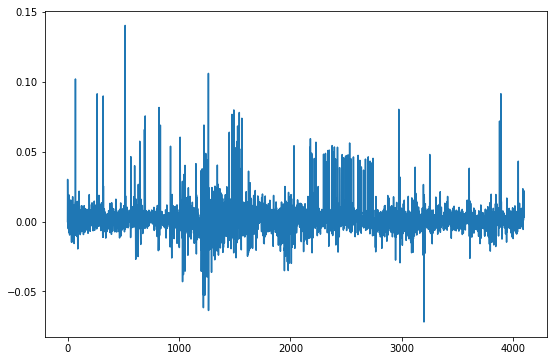

In [15]:
fig = plt.gcf()
fig.set_size_inches(9,6)

plt.plot(df["Return"])

In [17]:
df.describe()

,Return
count,4097.000000
mean,0.001940
std,0.011606
min,-0.071790
25%,-0.002870
50%,0.001230
75%,0.005710
max,0.140160


-----------------------
## 3) Load and prepare factors (Daily)
* First you need to download them or use the files attached on GitHub
* resulting in df_3, df_4, and df_5, all with 4095 rows
-----------------------

In [4]:

def find_header_and_load(full_path):

    pos= 0
    oldpos = None

    with open(full_path, 'r') as fp:

        # make sure we stop reading, in case we reach End of file
        while pos != oldpos:  
            line= fp.readline()
            if line.startswith(","):
                fp.seek(pos)                  
                break
            oldpos = pos 
            # remember this position as the start of the next line 
            pos = fp.tell()    

        df = pd.read_csv(fp)
        
    return df

# https://www.youtube.com/watch?v=SEURXzTgvKI
# https://stackoverflow.com/questions/14881885/python-pandas-read-csv-file-with-variable-preamble-length?fbclid=IwAR166rOeOxm16qJ7NWoB_tHz1M9JgfCIlORcsY3JaT0NNc5HYMObjRTzhpc

##############################################################################################################

def format_date_daily(df):

    df = df.rename(columns={'Unnamed: 0': 'Date'})
    df['Date'] = df['Date'].apply(str)
    
    try:                                                                 

        df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x,'%Y%m%d'))      
   
    # All the files had a list line wit hcopyright insteda of the data
    except:
        df = df[0:len(df)-1]                                                     
        df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x,'%Y%m%d'))  
        
    return df

    # Tough time, strtime vs. strftime, string conversion, deleting /no etc., not easily appliable
    # APPLY LAMBDA worked perfectly


In [6]:

# PATH for the factors, EU / US factors, and daily/monthly freq can be specified
# Mothly version didn't work properly 
# NOT SURE now, the first function with factors load might be redundant in the end

def factors_load(path, country, freq):
    
    if country == "EU":
        i = "EU"
    elif country == "US":
        i = "US"
    else:
        pass

    if freq == "daily":
        j = "daily"
    elif freq == "monthly":
        j = "monthly"
    else:
        pass


    fullpath1 = path + "Five_factors_" + i + "_" + j +".csv"
    fullpath2 = path +  "Momentum_" + i + "_" + j +".csv"
    fullpath3 = path + "Three_factors_" + i + "_" + j +".csv"
    
    if freq == "daily":
        df1 = format_date_daily(find_header_and_load(fullpath1))
        df2 = format_date_daily(find_header_and_load(fullpath2))
        df3 = format_date_daily(find_header_and_load(fullpath3))
        
    else:
        print("ERROR")
        
    return df1, df2, df3

############## EXECUTION: ##############

path = "C:/Users/Desktop/Python/factors/"

factors = factors_load(path, "EU", "daily")     # Actually works with EU daily and US daily.
                                                # Problem with other 2 combinations - there are some space-separated extra data rows
three = factors[2]
four = factors[1]
five = factors[0]

# This part cuts all the factors to the same matching length
length = min(len(three), len(four), len(five))

three = three.iloc[::-1].copy()    # Reverse order
three = three[0:length].copy()      # Cutting length
three = three.iloc[::-1].copy()     # Reverse order again

four = four.iloc[::-1].copy()
four = four[0:length].copy()
four = four.iloc[::-1].copy()

five = five.iloc[::-1].copy()
five = five[0:length].copy()
five = five.iloc[::-1].copy()

for i in (three, four, five):
    i = i[0:length]
    

    
three.reset_index(drop = True,inplace=True)
four.reset_index(drop = True,inplace=True)
five.reset_index(drop = True,inplace=True)

# four factor model = 3 factors + WML
four = pd.concat([three, four["WML"]], axis=1)  
four = four[["Date","Mkt-RF", "SMB", "HML","WML", "RF"]]

########################################################

def prepare_data(data, num_factors):
    
    if num_factors == "three":
        factors = [ "Mkt-RF", "SMB", "HML"]
        num_factors = three
    elif num_factors == "four":
        factors = [ "Mkt-RF", "SMB", "HML", "WML"]
        num_factors = four
    elif num_factors == "five":
        factors = [ "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
        num_factors = five
    else:
        pass        
    
    returns =  data[["Date","Return"]].dropna()
    returns.Date = returns.Date.astype(str)
    
    # This helped with the following merge
    num_factors.Date = num_factors.Date.astype(str)            
    
    # Excess returns = Returns minus Market-free rate
    data2 = pd.merge(returns, num_factors,how = "inner", on = "Date")
    data2["Excess"] = data2["Return"] - data2["RF"]               
    data2 = data2[1:]
    data2.reset_index(drop = True,inplace=True)
    
    # Excess 2 = excess shifted one step, so we will be able to predict tomorrow value 
    # Roll moves the first value to the end, we cannot work with the last observation
    data2["Excess2"] = np.roll(data2.Excess,-1)
    data2 = data2[:-1].copy()    

    display(data2.tail())
    
    return data2

############## EXECUTION: ##############
df_3 = prepare_data(df, "three")
df_4 = prepare_data(df, "four")
df_5 = prepare_data(df, "five")


,Date,Return,Mkt-RF,SMB,HML,RF,Excess,Excess2
4090,2019-12-23,0.00227,0.25,0.26,-0.26,0.01,-0.00773,0.01215
4091,2019-12-24,0.02215,0.10,0.13,-0.03,0.01,0.01215,-0.00707
4092,2019-12-25,0.00293,0.06,0.01,0.00,0.01,-0.00707,-0.00617
4093,2019-12-27,0.00383,0.91,0.29,-0.19,0.01,-0.00617,0.01154
4094,2019-12-30,0.02154,-0.52,0.74,0.23,0.01,0.01154,-0.00506


,Date,Return,Mkt-RF,SMB,HML,WML,RF,Excess,Excess2
4090,2019-12-23,0.00227,0.25,0.26,-0.26,0.12,0.01,-0.00773,0.01215
4091,2019-12-24,0.02215,0.10,0.13,-0.03,0.10,0.01,0.01215,-0.00707
4092,2019-12-25,0.00293,0.06,0.01,0.00,0.00,0.01,-0.00707,-0.00617
4093,2019-12-27,0.00383,0.91,0.29,-0.19,0.24,0.01,-0.00617,0.01154
4094,2019-12-30,0.02154,-0.52,0.74,0.23,-0.31,0.01,0.01154,-0.00506


,Date,Return,Mkt-RF,SMB,HML,RMW,CMA,RF,Excess,Excess2
4090,2019-12-23,0.00227,0.25,0.23,-0.26,-0.11,-0.16,0.01,-0.00773,0.01215
4091,2019-12-24,0.02215,0.10,0.11,-0.03,-0.07,0.00,0.01,0.01215,-0.00707
4092,2019-12-25,0.00293,0.06,0.01,0.00,0.01,0.00,0.01,-0.00707,-0.00617
4093,2019-12-27,0.00383,0.91,0.29,-0.19,0.18,-0.10,0.01,-0.00617,0.01154
4094,2019-12-30,0.02154,-0.52,0.74,0.23,-0.23,0.18,0.01,0.01154,-0.00506


-----------------------
## 4) ARIMA
* TIME: 5-13 min
* predictions_ARIMA
* RMSE_Arima
* MAE_Arima
-----------------------

### 4.1) Autocorrelation & ACF
* Here we can see for any (3,4,5) the Excess returns correlations are converging to zero, suggesting no Unit root
* ACF suggests AR(1)

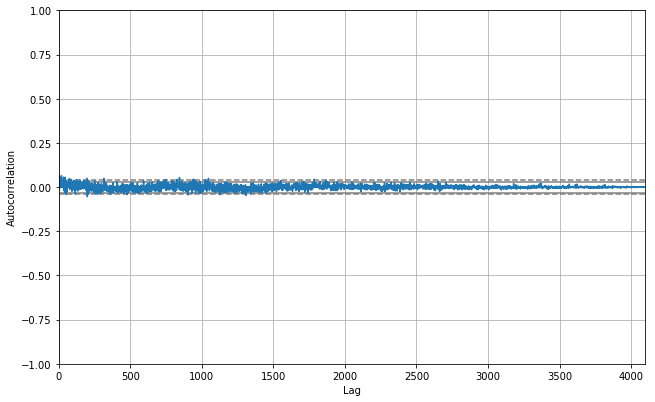

In [47]:
def autocorr_plots(df):

    autocorrelation_plot(df["Return"])

    fig = plt.gcf()
    fig.set_size_inches(10.5, 6.5)
    #plt.xlim(left = 0, right = 20)
    #plt.ylim(top = 0.5, bottom = -0.5)
    
autocorr_plots(df_5)

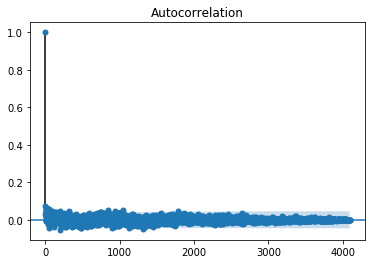

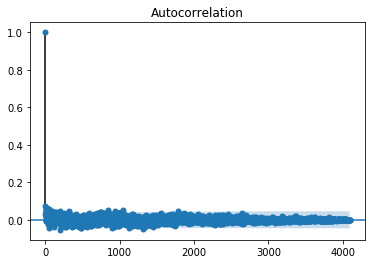

In [49]:
plot_acf(df_3["Return"])

### 4.2) ADF test for Unit root
* p-value lower than 1% crit. values tells there is no unit root at even 99% confidence level

In [53]:
X = df_3["Excess"].dropna().values 

result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.540949
p-value: 0.006996
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### 4.3) ARIMA model
* Model (1,0,0) give statisically significant coefficients
* For (1,0,1) are both coefficients close to 1 suggesting need to remove one of them
* Thus, (1,0,0) seems to be the best

In [57]:
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

model = ARIMA(df_3["Excess"].dropna(), order=(1,0,0))    
model_fit = model.fit(disp=0)                                  
print(model_fit.summary()) 
#print(model_fit.summary().as_latex())


                              ARMA Model Results                              
Dep. Variable:                 Excess   No. Observations:                 4095
Model:                     ARMA(1, 0)   Log Likelihood               12016.760
Method:                       css-mle   S.D. of innovations              0.013
Date:                Tue, 06 Oct 2020   AIC                         -24027.520
Time:                        16:05:35   BIC                         -24008.567
Sample:                             0   HQIC                        -24020.810
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0030      0.000    -10.098      0.000      -0.004      -0.002
ar.L1.Excess     0.3208      0.015     21.654      0.000       0.292       0.350
                                    Roots   

### 4.4) ARIMA(1,0,0) training + test
* TIME: 5-13 min
* predictions_ARIMA
* RMSE_Arima
* MAE_Arima

In [ ]:
X = df_3["Excess"].dropna().values
display(len(X))

# Train set = 0.80
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history_arima = [x for x in train]
predictions_arima = list()


for t in range(len(test)):   
    ###Problems with ARIMA(), need to use SARIMAX with the same parameters
    #model = ARIMA(history, order=(1,0,0))   
    
    model = sm.tsa.SARIMAX(history_arima, order=(1,0,0), enforce_stationarity=False, enforce_invertibility=False)
    
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions_arima.append(yhat)
    history_arima.append(test[t])
    
predictions_ARIMA = predictions_arima.copy()

In [38]:
# ERRORS
RMSE_Arima = sqrt(mean_squared_error(test, predictions_ARIMA))
print('Test RMSE: %.6f' % RMSE_Arima)
MAE_Arima = mean_absolute_error(test, predictions_ARIMA)
print('Test MAE: %.6f' % MAE_Arima)

Test RMSE: 0.008946
Test MAE: 0.006347


4095

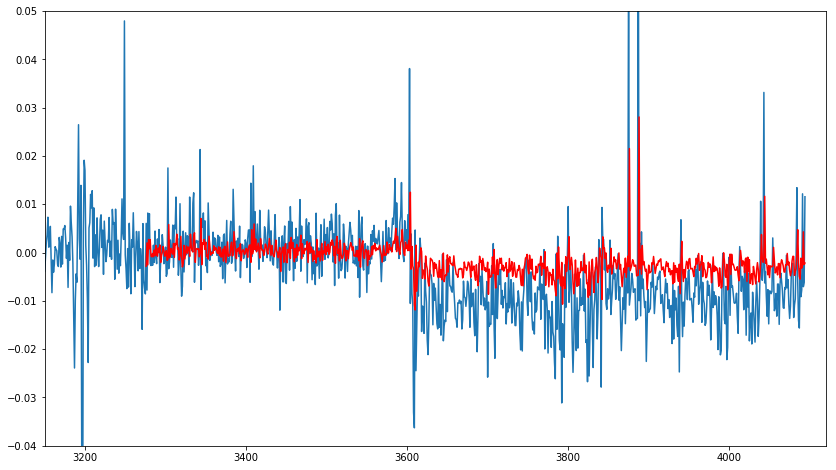

In [60]:
nullsy = [0]
nullsy *= size
nullsy[0:5]

predictions_ARIMA_full = nullsy + predictions_ARIMA
display(len(predictions_ARIMA_full))

# replacing nulls with NaNs
predictions_ARIMA_full = [np.nan if (x==0) else x for x in predictions_ARIMA_full]  
predictions_ARIMA_full[0:5]

fig = plt.gcf()
fig.set_size_inches(14,8)

plt.plot(df_3["Excess"].dropna().values)    ###DATA vs DATA_OLS_3  // Excess
plt.plot(predictions_ARIMA_full, color='red')
plt.xlim(left = 3150, right = 4120)
plt.ylim(bottom = -0.04, top = 0.05)

plt.show()

-----------------------
## 5) Random Walk
* TIME: < 1 min
* predictions_RW
* RMSE_RW
* MAE_RW
-----------------------

4095

Test RMSE: 0.010033
Test MAE: 0.006339


4095

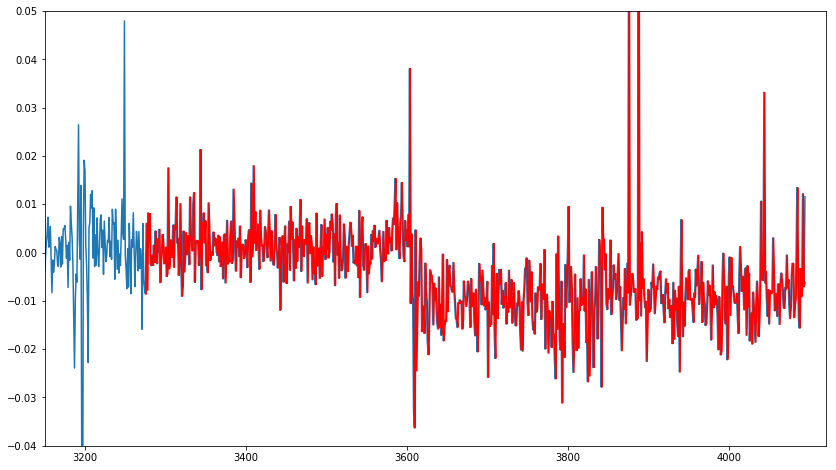

In [82]:
# https://machinelearningmastery.com/gentle-introduction-random-walk-times-series-forecasting-python/

X = df_3["Excess"].dropna().values    
display(len(X))                            

#Train set = again 0.80
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history_rw = [x for x in train]
predictions_rw = list()
history_rw = train[-1]

# First test value continues on the last train value
for i in range(len(test)):    
    yhat = history_rw
    predictions_rw.append(yhat)
    history_rw = test[i]
    
predictions_RW = predictions_rw.copy()

RMSE_RW = sqrt(mean_squared_error(test, predictions_RW))
print('Test RMSE: %.6f' % RMSE_RW)

MAE_RW = mean_absolute_error(test, predictions_RW)
print('Test MAE: %.6f' % MAE_RW)

fig = plt.gcf()
fig.set_size_inches(14,8)

#################################
nullsy = [0]
nullsy *= size
nullsy[0:5]

predictions_RW_full = nullsy + predictions_RW
display(len(predictions_RW_full))

predictions_RW_full = [np.nan if (x==0) else x for x in predictions_RW_full]   #zabvení se NUL, místo nich NANs, abych mohl plotovat rpedikce

plt.plot(df_3["Excess"])
plt.plot(predictions_RW_full, color='red')
plt.xlim(left = 3150, right = 4120)
plt.ylim(bottom = -0.04, top = 0.05)
    
plt.show()

-----------------------
## 6) OLS - 3,4,5 factors
* when running OLS, one muset specify dataset (df_3, df_4, df_5) and factors ("CAPM", "three", "four", "five")
* Also need to decide whether to use Excess or Excess2 - current value or one-step-ahead value (for prediction purposes)
* In that case, do not forget to change output names in the end of cell to not overwrite previous results
* RESULTS:
* predictions_Factors_3
* RMSE_Factors_3
* MAE_Factors_3
* etc. 4, 5
-----------------------

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Excess2   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     33.82
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           1.61e-21
Time:                        12:11:09   Log-Likelihood:                 9283.1
No. Observations:                3276   AIC:                        -1.856e+04
Df Residuals:                    3272   BIC:                        -1.853e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.000    -10.480      0.000      -0.003      -0.002
Mkt-RF         0.0023      0.000      8.104      0.000       0.002       0.003
SMB            0.0032      0.001      5.060      0.000       0.002       0.004
HML            0.0018      0.001      2.947      0.003       0.001       0.003
==============================================================================
Omnibus:                     1221.390   Durbin-Watson:                   1.519
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12678.907
Skew:                           1.470   Prob(JB):                         0.00
Kurtosis:                      12.179   Cond. No.                         3.71
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'R2 is : 0.030074896493472836'

Test RMSE: 0.008891
Test MAE: 0.006591
Length data: 4095


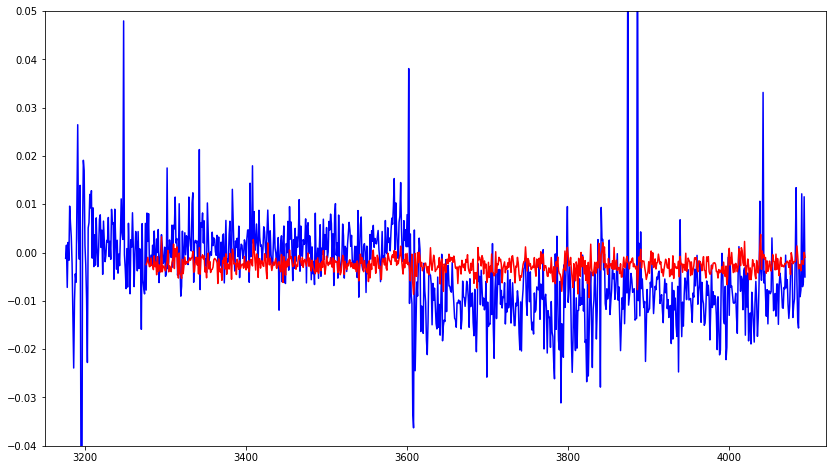

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Excess2   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     27.60
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           1.43e-22
Time:                        12:11:09   Log-Likelihood:                 9287.4
No. Observations:                3276   AIC:                        -1.856e+04
Df Residuals:                    3271   BIC:                        -1.853e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.000    -10.316      0.000      -0.003      -0.002
Mkt-RF         0.0021      0.000      7.644      0.000       0.002       0.003
SMB            0.0034      0.001      5.350      0.000       0.002       0.005
HML            0.0013      0.001      2.032      0.042    4.49e-05       0.003
WML           -0.0011      0.000     -2.952      0.003      -0.002      -0.000
==============================================================================
Omnibus:                     1222.786   Durbin-Watson:                   1.521
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12723.651
Skew:                           1.471   Prob(JB):                         0.00
Kurtosis:                      12.196   Cond. No.                         3.88
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'R2 is : 0.03265241193578128'

Test RMSE: 0.008919
Test MAE: 0.006589
Length data: 4095


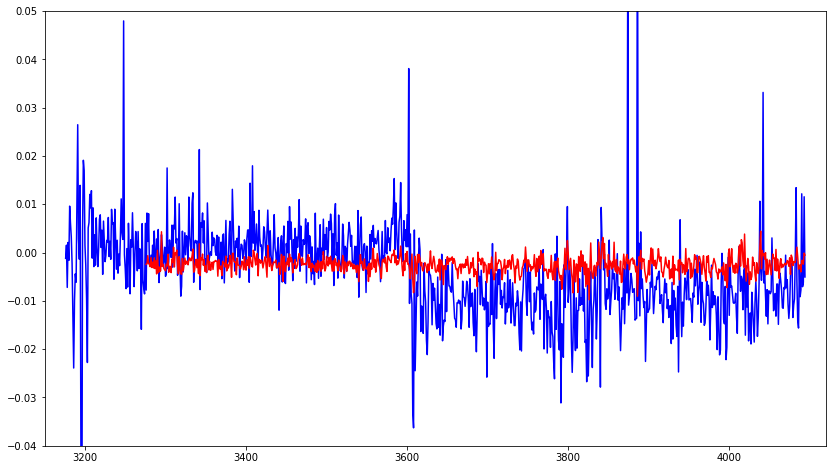

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Excess2   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     20.45
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           3.67e-20
Time:                        12:11:10   Log-Likelihood:                 9283.5
No. Observations:                3276   AIC:                        -1.855e+04
Df Residuals:                    3270   BIC:                        -1.852e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.000    -10.505      0.000      -0.003      -0.002
Mkt-RF         0.0022      0.000      7.451      0.000       0.002       0.003
SMB            0.0032      0.001      5.036      0.000       0.002       0.004
HML            0.0020      0.001      2.705      0.007       0.001       0.003
RMW            0.0007      0.001      0.682      0.495      -0.001       0.003
CMA           -0.0005      0.001     -0.487      0.626      -0.002       0.001
==============================================================================
Omnibus:                     1223.039   Durbin-Watson:                   1.521
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12800.587
Skew:                           1.470   Prob(JB):                         0.00
Kurtosis:                      12.227   Cond. No.                         6.59
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'R2 is : 0.030327397484602003'

Test RMSE: 0.008885
Test MAE: 0.006588
Length data: 4095


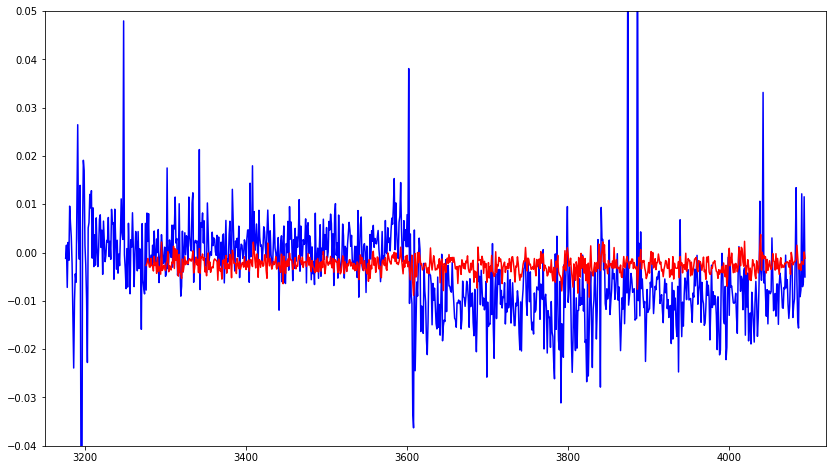

In [64]:
def run_OLS(data, num_factors, split):
    
    # specifying CAPM,3,4,5 factors
    if num_factors == "CAPM":
        factors = [ "Mkt-RF"]
    elif num_factors == "three":
        factors = [ "Mkt-RF", "SMB", "HML"]
        num_factors = three
    elif num_factors == "four":
        factors = [ "Mkt-RF", "SMB", "HML", "WML"]
        num_factors = four
    elif num_factors == "five":
        factors = [ "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
        num_factors = five
    else:
        pass
    
    # Depends on which dataset we use, it must be compatible with the factors we want to work with
    # e.g. (df_4, "four", 0.8)
    X = data[factors]
    
    # Here we may decide whether to use Excess or Excess2 - current value or one-step-ahead value
    y = data[["Excess2"]] 

    train_X = X[0:round(split*len(X))]
    train_y = y[0:round(split*len(y))]
    #rint("Length of train set: " + str(len(train_y)))

    test_X = X[round(split*len(X)):]
    test_y = y[round(split*len(y)):]
    #rint("Length of test set: " + str(len(test_y)))
    
    # Adding constant to the OLS
    train_X = sm.add_constant(train_X)  
    test_X = sm.add_constant(test_X)
    
    
    model = sm.OLS(train_y, train_X).fit()
    predictions = model.predict(test_X) 
    display(model.summary())                
    display("R2 is : " + str(model.rsquared))
    
    residuals = test_y - predictions
    
    
    RMSE_Factors = sqrt(mean_squared_error(test_y, predictions))  
    print('Test RMSE: %.6f' % RMSE_Factors)
    MAE_Factors = mean_absolute_error(test_y, predictions)
    print('Test MAE: %.6f' % MAE_Factors)
    
    print("Length data: " + str(len(data)))                                                 
    
    plt.plot(y[round(split*len(y))-100:], color = "blue")    
    plt.plot(predictions, color='red')                       

    fig = plt.gcf()
    fig.set_size_inches(14, 8)
    plt.xlim(left = 3150, right = 4120)
    plt.ylim(bottom = -0.04, top = 0.05)

    plt.show()
    
    #print(model.summary().as_latex())    

    return RMSE_Factors, MAE_Factors, predictions, residuals
    
#RMSE_Factors_CAPM, MAE_Factors_CAPM, predictions_Factors_CAPM , residuals_CAPM = run_OLS(data_OLS_3, "CAPM", 0.8) 
RMSE_Factors_3, MAE_Factors_3, predictions_Factors_3, residuals_Factors_3 = run_OLS(df_3, "three", 0.8)   
RMSE_Factors_4, MAE_Factors_4, predictions_Factors_4, residuals_Factors_4 = run_OLS(df_4, "four", 0.8)  
RMSE_Factors_5, MAE_Factors_5, predictions_Factors_5, residuals_Factors_5 = run_OLS(df_5, "five", 0.8)  


-----------------------
## 7) LSTM - lags of returns
* https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/
* https://machinelearningmastery.com/time-series-forecasting-supervised-learning/
* https://machinelearningmastery.com/start-here/#lstm
* https://machinelearningmastery.com/5-step-life-cycle-long-short-term-memory-models-keras/
* https://machinelearningmastery.com/long-short-term-memory-recurrent-neural-networks-mini-course/
* https://www.datacamp.com/community/tutorials/lstm-python-stock-market
* https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
* https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
----------------------
* stepback parameter needs to be set up
* all the aprameters in model.compile() and model.fit() might be modified
* RESULTS:
* testPredict_NN_full
* RMSE_NN
* MAE_NN
-----------------------

### 7.1) Preparing Data and model

In [43]:
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
#########################################

np.random.seed(7)
y = df_3["Excess"]    
# Nescessary for further moves
y = y.values             
y = y.astype('float32')
# Final shape will have 1 column
y = y.reshape(-1, 1)

splitty = 0.8

train_size = int(len(y) * splitty) 
test_size = len(y) - train_size    
train = y[0:train_size, :]
test = y[train_size:len(y), :] 

# Standardizing train and test set separately
mean_train = train.mean(axis=0)
std_train = train.std(axis = 0)
train -= mean_train
train /= std_train
#
mean_test = test.mean(axis=0)
std_test = test.std(axis = 0)
test -= mean_test
test /= std_test

def create_dataset(dataset, stepback = 1):    
    dataX, dataY = [], []
    for i in range(len(dataset)-stepback):
        a = dataset[i:(i+stepback), 0] 
        b = dataset[i + stepback, 0]
        dataX.append(a)                         
        dataY.append(b) 
    return np.array(dataX), np.array(dataY)
         
# stepback parameter determines the shape of input and also the number of remaining observations    
stepback = 5                                          
train_X, train_y = create_dataset(train, stepback)
test_X, test_y = create_dataset(test, stepback)

# reshape input data
train_X = np.reshape(train_X, (train_X.shape[0],1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))    
len(test_X) 

### for plotting, we need to shift predcitions forward??

# 2 Hidden layers with LSTM Cells, Input layer is defined by input_shape
model = Sequential()
model.add(LSTM(8, dropout= 0.20, return_sequences = True, input_shape=(1, stepback)))
model.add(LSTM(8, dropout= 0.20))
model.add(Dense(1))    


model.compile(loss='mean_squared_error', optimizer= "adam", metrics= ['accuracy']) 

history = model.fit(train_X, train_y, epochs=4, batch_size=1, verbose=2, validation_split=0.2) # verbose ovlivnuje outputy   # nově Validation

print(history.history['loss'])     

Train on 2616 samples, validate on 655 samples
Epoch 1/4
 - 8s - loss: 0.9282 - acc: 0.0000e+00 - val_loss: 0.5039 - val_acc: 0.0000e+00
Epoch 2/4
 - 6s - loss: 0.8817 - acc: 0.0000e+00 - val_loss: 0.4990 - val_acc: 0.0000e+00
Epoch 3/4
 - 6s - loss: 0.8684 - acc: 0.0000e+00 - val_loss: 0.5097 - val_acc: 0.0000e+00
Epoch 4/4
 - 6s - loss: 0.8582 - acc: 0.0000e+00 - val_loss: 0.5090 - val_acc: 0.0000e+00
[0.9282111757499971, 0.8816756859390545, 0.8683801378679704, 0.858249364266315]


### 7.2) Plotting Predictions & RMSE, MAE

In [44]:
# make predictions
testPredict_NN = model.predict(test_X)

# invert-standardizing predictions
testPredict_NN *= std_test
testPredict_NN += mean_test
test_y *= std_test
test_y += mean_test

nullsy = np.zeros((train_size + stepback, 1 ))
testPredict_NN_full = np.vstack((nullsy, testPredict_NN))
#putting NaNs instead of nulls
testPredict_NN_full = [np.nan if (x==0) else x for x in testPredict_NN_full]   

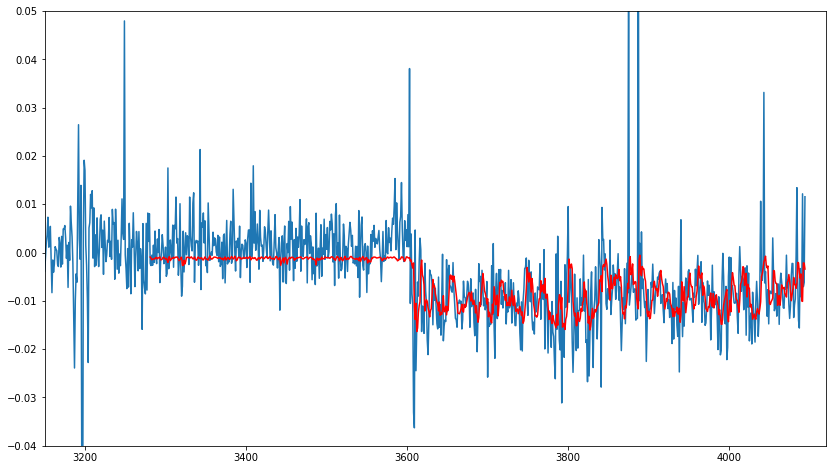

In [45]:
fig = plt.gcf()
fig.set_size_inches(14, 8)
plt.xlim(left = 3150, right = 4120)
plt.ylim(bottom = -0.04, top = 0.05)
plt.plot(df_3["Excess"])
plt.plot(testPredict_NN_full, color='red')

plt.show()

### When the values were close to zero, predctions went really close to zero, too ?!

In [46]:
# RMSE & MAE
RMSE_NN = math.sqrt(mean_squared_error(test_y, testPredict_NN[:,0]))
print('RMSE NN test: %.6f' % (RMSE_NN))

MAE_NN = mean_absolute_error(test_y, testPredict_NN[:,0])
print('MAE NN test: %.6f' % MAE_NN)


RMSE NN test: 0.007710
MAE NN test: 0.005091


-----------------------
## 8) LSTM - lags of returns + Factors
* https://machinelearningmastery.com/promise-recurrent-neural-networks-time-series-forecasting/
----------------------
* one must specify dataset (df_3, df_4, df_5) and load as many factors are needed. First three by default, plus 4th optional or 4th + 5th optional (4th and 4+5th are different factors)
* stepback parameter needs to be chosen
* there is an optional parameter future, if we want to predict more than following day, e.g. 5th day, we use future = 4
* RESULTS:
* testPredict_NN_FF3_full
* RMSE_NN_FF3
* MAE_NN_FF3
* eventually FF3, FF4, FF5
-----------------------

### 8.1) Basic 3-factor data

In [94]:

################################
# This section needs to be set according to the factors we want to work with !!

data_NN = df_3.copy()  ### This is crurical !! 

splitty = 0.8  
stepback =  5     
future = 0          
###############################
# Hold the same notes as for 7.1)
###############################

def create_dataset(dataset, stepback = 1):  
    dataX, dataY = [], []
    for i in range(len(dataset)-stepback):   
        a = dataset[i:(i+stepback), 0] 
        b = dataset[i + stepback, 0]
        dataX.append(a)                         
        dataY.append(b) 
    return np.array(dataX), np.array(dataY)


d = data_NN["Excess"]    
d = d.values
d = d.astype("float32")
d = d.reshape(-1, 1)     

train_size = int(len(d) * splitty)
train = d[0:train_size, :]
test = d[train_size:len(d), :]

mean_train_returns = train.mean(axis=0)
std_train_returns = train.std(axis = 0)
train -= mean_train_returns
train /= std_train_returns

mean_test_returns = test.mean(axis=0)  
std_test_returns = test.std(axis = 0)    
test -= mean_test_returns
test /= std_test_returns


train_X, train_y = create_dataset(train, stepback)
test_X, test_y = create_dataset(test, stepback)

train_X = np.reshape(train_X, (train_X.shape[0],1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))        

# Possible future prediction, if FUTURE > 0, excess values are rolled forward
train_y = np.roll(train_y,-future)
train_y = train_y[:len(train_y)-future]
test_y = np.roll(test_y,-future)
test_y = test_y[:len(test_y)-future]
train_X = train_X[:len(train_X)-future]
test_X = test_X[:len(test_X)-future]


train_X_all = train_X.copy()
test_X_all = test_X.copy()
train_y_all = train_y.copy()
test_y_all = test_y.copy()

######################################################################################
## 1st factor

d = data_NN["Mkt-RF"]
d = d.values
d = d.astype("float32")
d = d.reshape(-1, 1)

train_size = int(len(d) * splitty)
train = d[0:train_size, :]
test = d[train_size:len(d), :]

mean_train_Mkt = train.mean(axis=0)    
std_train_Mkt = train.std(axis = 0)
train -= mean_train_Mkt
train /= std_train_Mkt
#
mean_test_Mkt = test.mean(axis=0)    
std_test_Mkt = test.std(axis = 0)    
test -= mean_test_Mkt
test /= std_test_Mkt

train_X, train_y_NOT = create_dataset(train, stepback)
test_X, test_y_NOT = create_dataset(test, stepback)

train_X = np.reshape(train_X, (train_X.shape[0],1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))        

train_X = train_X[:len(train_X)-future]
test_X = test_X[:len(test_X)-future]

# Train and test sets for X are concatenated to the previous one. Y sets remain the same (Returns)
train_X_all = np.concatenate((train_X_all,train_X),axis=2)
test_X_all = np.concatenate((test_X_all,test_X),axis=2)

######################################################################################
## 2nd factor

d = data_NN["SMB"]
d = d.values
d = d.astype("float32")
d = d.reshape(-1, 1)

train_size = int(len(d) * splitty)
train = d[0:train_size, :]
test = d[train_size:len(d), :]


mean_train_SMB = train.mean(axis=0)
std_train_SMB = train.std(axis = 0)
train -= mean_train_SMB
train /= std_train_SMB

mean_test_SMB = test.mean(axis=0)   
std_test_SMB = test.std(axis = 0)  
test -= mean_test_SMB
test /= std_test_SMB

train_X, train_y_NOT = create_dataset(train, stepback)
test_X, test_y_NOT = create_dataset(test, stepback)

train_X = np.reshape(train_X, (train_X.shape[0],1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))        


train_X = train_X[:len(train_X)-future]
test_X = test_X[:len(test_X)-future]

train_X_all = np.concatenate((train_X_all,train_X),axis=2)
test_X_all = np.concatenate((test_X_all,test_X),axis=2)

######################################################################################
## 3rd factor

d = data_NN["HML"]
d = d.values
d = d.astype("float32")
d = d.reshape(-1, 1)

train_size = int(len(d) * splitty)
train = d[0:train_size, :]
test = d[train_size:len(d), :]

mean_train_HML = train.mean(axis=0)
std_train_HML = train.std(axis = 0)
train -= mean_train_HML
train /= std_train_HML

mean_test_HML = test.mean(axis=0)    
std_test_HML = test.std(axis = 0)    
test -= mean_test_HML
test /= std_test_HML

train_X, train_y_NOT = create_dataset(train, stepback)
test_X, test_y_NOT = create_dataset(test, stepback)

train_X = np.reshape(train_X, (train_X.shape[0],1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))        

train_X = train_X[:len(train_X)-future]
test_X = test_X[:len(test_X)-future]

train_X_all = np.concatenate((train_X_all,train_X),axis=2)
test_X_all = np.concatenate((test_X_all,test_X),axis=2)


### 8.2) Fourth additional factor
* necessary to select  df_4 in the previous cell
* It simply concatenates this additional input data to the 3 factor model

In [ ]:
######################################################################################
## 4th factor

d = data_NN["WML"]
d = d.values
d = d.astype("float32")
d = d.reshape(-1, 1)

train_size = int(len(d) * splitty)
train = d[0:train_size, :]
test = d[train_size:len(d), :]

mean_train_WML = train.mean(axis=0)
std_train_WML = train.std(axis = 0)
train -= mean_train_WML
train /= std_train_WML

mean_test_WML = test.mean(axis=0)   
std_test_WML = test.std(axis = 0)   
test -= mean_test_WML
test /= std_test_WML

train_X, train_y_NOT = create_dataset(train, stepback)
test_X, test_y_NOT = create_dataset(test, stepback)

train_X = np.reshape(train_X, (train_X.shape[0],1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))        

train_X = train_X[:len(train_X)-future]
test_X = test_X[:len(test_X)-future]

train_X_all = np.concatenate((train_X_all,train_X),axis=2)
test_X_all = np.concatenate((test_X_all,test_X),axis=2)

### 8.3) Fourth+Fifth additional factors
#### If not needed, skip to 8.5) Model
* necessary to select df_5 in the cell above the previous one
* It simply concatenates this additional input data to the 3 factor model

In [96]:
######################################################################################
## 4th factor

d = data_NN["RMW"]
d = d.values
d = d.astype("float32")
d = d.reshape(-1, 1)

train_size = int(len(d) * splitty)
train = d[0:train_size, :]
test = d[train_size:len(d), :]

mean_train_RMW = train.mean(axis=0)
std_train_RMW = train.std(axis = 0)
train -= mean_train_RMW
train /= std_train_RMW

mean_test_RMW = test.mean(axis=0)    
std_test_RMW = test.std(axis = 0)     
test -= mean_test_RMW
test /= std_test_RMW

train_X, train_y_NOT = create_dataset(train, stepback)
test_X, test_y_NOT = create_dataset(test, stepback)

train_X = np.reshape(train_X, (train_X.shape[0],1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))        

train_X = train_X[:len(train_X)-future]
test_X = test_X[:len(test_X)-future]

train_X_all = np.concatenate((train_X_all,train_X),axis=2)
test_X_all = np.concatenate((test_X_all,test_X),axis=2)

######################################################################################
## 5th factor

d = data_NN["CMA"]
d = d.values
d = d.astype("float32")
d = d.reshape(-1, 1)

train_size = int(len(d) * splitty)
train = d[0:train_size, :]
test = d[train_size:len(d), :]

mean_train_CMA = train.mean(axis=0)
std_train_CMA = train.std(axis = 0)
train -= mean_train_CMA
train /= std_train_CMA

mean_test_CMA = test.mean(axis=0)     
std_test_CMA = test.std(axis = 0)    
test -= mean_test_CMA
test /= std_test_CMA

train_X, train_y_NOT = create_dataset(train, stepback)
test_X, test_y_NOT = create_dataset(test, stepback)

train_X = np.reshape(train_X, (train_X.shape[0],1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))        

train_X = train_X[:len(train_X)-future]
test_X = test_X[:len(test_X)-future]

train_X_all = np.concatenate((train_X_all,train_X),axis=2)
test_X_all = np.concatenate((test_X_all,test_X),axis=2)


### 8.4) Shape check
#### If not needed, skip to 8.5) Model
* should equal to (0.8 x 4095 - stepback; 1; (factors + 1 ) x stepback)
* e.g., for 3 factors: (3271, 1, 20)

In [18]:
train_X_all.shape

(3271, 1, 20)

### 8.5) Model
* Layers, neurons, dropout, loss, optimizer, epochs, batch - all can be changed

In [97]:

model = Sequential()
model.add(LSTM(16, dropout= 0.20, return_sequences = True, input_shape=(1, train_X_all.shape[2])))
model.add(LSTM(16, dropout= 0.20))
model.add(Dense(1))    

model.compile(loss='mean_squared_error', optimizer= "adam") 

model.fit(train_X_all, train_y_all, epochs= 4, batch_size=1, verbose=2) 

Epoch 1/4
 - 12s - loss: 0.8160
Epoch 2/4
 - 11s - loss: 0.7591
Epoch 3/4
 - 11s - loss: 0.7518
Epoch 4/4
 - 9s - loss: 0.7429


### 8.6) Plotting Predictions & RMSE, MAE
* If you want t osave predictions (for Mariano-Diebold test), you need to change name of NN_FF_full to NN_FF3_full or smth. like that, to not overwrite results. 
* The same applies for RMSE and MAE in next cell

4095

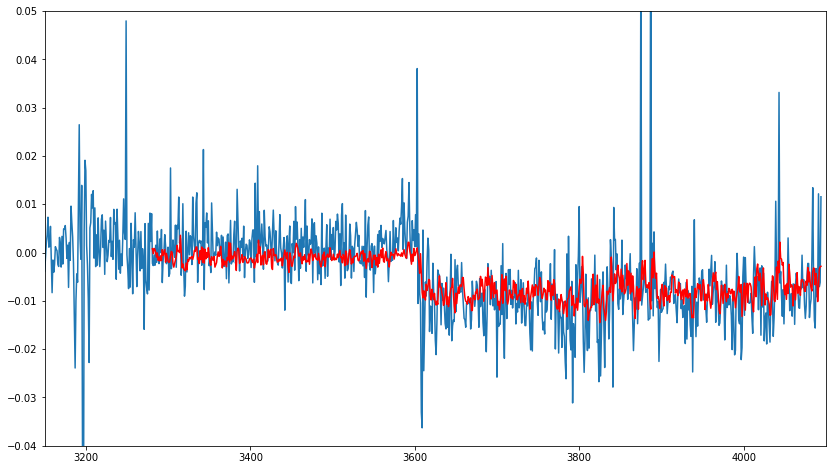

In [98]:
testPredict_all = model.predict(test_X_all)

testPredict_all *= std_test_returns
testPredict_all += mean_test_returns

test_y_all *= std_test_returns
test_y_all += mean_test_returns

nullsy = np.zeros((train_size + stepback + future, 1 )) 

testPredict_NN_FF_full = np.vstack((nullsy, testPredict_all))
display(len(testPredict_NN_FF_full))

testPredict_NN_FF_full = [np.nan if (x==0) else x for x in testPredict_NN_FF_full]   


fig = plt.gcf()
fig.set_size_inches(14, 8)
plt.plot(df_3["Excess"])
plt.plot(testPredict_NN_FF_full, color='red')
plt.xlim(left = 3150, right = 4100)
plt.ylim(bottom = -0.04, top = 0.05)

plt.show()

In [92]:
RMSE_NN_FF = math.sqrt(mean_squared_error(test_y_all, testPredict_all[:,0]))
print('RMSE NN FF X: %.6f' % (RMSE_NN_FF))

MAE_NN_FF = mean_absolute_error(test_y_all, testPredict_all[:,0])
print('MAE NN FF X: %.6f' % MAE_NN_FF)

RMSE NN FF X: 0.007497
MAE NN FF X: 0.004806


-----------------------
## 9) Results + Mariano-Diebold test
-----------------------

### 9.1) All RMSE & MAE

In [66]:
print("--------------")

## RW:
print('RMSE RW: %.6f' % RMSE_RW)
print('MAE RW: %.6f' % MAE_RW)
print("--------------")
## ARIMA:
print('RMSE ARIMA: %.6f' % RMSE_Arima)
print('MAE ARIMA: %.6f' % MAE_Arima)
print("--------------")
## OLS Factors:
print('RMSE Factors 3: %.6f' % RMSE_Factors_3)
print('MAE Factors 3: %.6f' % MAE_Factors_3)
print('RMSE Factors 4: %.6f' % RMSE_Factors_4)
print('MAE Factors 4: %.6f' % MAE_Factors_4)
print('RMSE Factors 5: %.6f' % RMSE_Factors_5)
print('MAE Factors 5: %.6f' % MAE_Factors_5)
print("--------------")
## OLS Factors one-step-haead prediction:
print('RMSE Factors 3, 1 step pred.: %.6f' % RMSE_Factors_3_pred)
print('MAE Factors 3, 1 step pred.: %.6f' % MAE_Factors_3_pred)
print('RMSE Factors 4, 1 step pred.: %.6f' % RMSE_Factors_4_pred)
print('MAE Factors 4, 1 step pred.: %.6f' % MAE_Factors_4_pred)
print('RMSE Factors 5, 1 step pred.: %.6f' % RMSE_Factors_5_pred)
print('MAE Factors 5, 1 step pred.: %.6f' % MAE_Factors_5_pred)
print("--------------")
## NN
print('RMSE NN: %.6f' % (RMSE_NN))
print('MAE NN: %.6f' % MAE_NN)
print("--------------")

## NN FF stepback 5
print('RMSE NN_FF3: %.6f' % (RMSE_NN_FF3))
print('MAE NN_FF3: %.6f' % MAE_NN_FF3)
print('RMSE NN_FF4: %.6f' % (RMSE_NN_FF4))
print('MAE NN_FF4: %.6f' % MAE_NN_FF4)
print('RMSE NN_FF5: %.6f' % (RMSE_NN_FF5))
print('MAE NN_FF5: %.6f' % MAE_NN_FF5)
print("--------------")



--------------
RMSE RW: 0.010033
MAE RW: 0.006339
--------------
RMSE ARIMA: 0.008946
MAE ARIMA: 0.006347
--------------
RMSE Factors 3: 0.008771
MAE Factors 3: 0.006680
RMSE Factors 4: 0.008769
MAE Factors 4: 0.006675
RMSE Factors 5: 0.008778
MAE Factors 5: 0.006682
--------------
RMSE Factors 3, 1 step pred.: 0.008891
MAE Factors 3, 1 step pred.: 0.006591
RMSE Factors 4, 1 step pred.: 0.008919
MAE Factors 4, 1 step pred.: 0.006589
RMSE Factors 5, 1 step pred.: 0.008885
MAE Factors 5, 1 step pred.: 0.006588
--------------
RMSE NN: 0.007710
MAE NN: 0.005091
--------------
RMSE NN_FF3: 0.007581
MAE NN_FF3: 0.004935
RMSE NN_FF4: 0.007605
MAE NN_FF4: 0.004856
RMSE NN_FF5: 0.007557
MAE NN_FF5: 0.004919
--------------


### 9.2) Mariano-Diebold (function)
* Predictions of the NNs are shorter due to stepback
* thus, the other predcitions need to be cut [5:]

In [67]:

def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)  
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")  
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True

        return (rt,msg)
    
    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np
    
    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []
    
    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
    
    # Length of lists (as real numbers)
    T = float(len(actual_lst))
    
    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)    
    
    # Mean of d        
    mean_d = pd.Series(d_lst).mean()
    
    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)
    
    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')
    
    rt = dm_return(DM = DM_stat, p_value = p_value)
    
    return rt

### Little trick to change 2D list into 1D list
* applied for each NN predictions

In [127]:
p2 = []

#for i in range(len(predictions_NN_FF5)):
#    p2.append(predictions_NN_FF5[i][0])
#predictions_NN_FF5 = p2.copy()

### 9.3) M-D test
* MAD / MSE can be chosen
* If comparing to NNs, actual values and RW and ARIMA must be [5:]
* if p-value is < 0.05, both sets predictions are significantly different to each other (i.e., one set is lower)

In [129]:
rt = dm_test(actual_vals[5:], predictions_ARIMA[5:] , predictions_NN_FF5, h = 1, crit="MAD")
print(rt)


dm_return(DM=11.235130275619436, p_value=2.5093178945581247e-27)
